In [5]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import sys
from matplotlib import cm
sys.path.append("..")
import scipy.sparse
import sklearn.manifold
from world_rando.model_checking import *
from functools import reduce

In [8]:
out_path = Path("../output")
rules, tests = parse_rules.parse_rules(["../encoding/rules/rules.yaml",
        "../encoding/rules/model_checking_tests/model_checking_tests.yaml"])
c1 = verify(tests["ModifiedConstructionZone1"], rules.values(), no_softlocks, out_path, no_softlocks_inner)
c2 = verify(tests["ModifiedConstructionZone2"], rules.values(), no_softlocks, out_path, no_softlocks_inner)

Search to reach None from c(39,9)


  3%|▎         | 103/3645 [00:00<00:03, 1023.67it/s]

Applied 3646 rules
Enumerated 3645 states in 3.9573184999999995 seconds


100%|██████████| 3645/3645 [00:04<00:00, 906.23it/s] 


Number of States: 3645
Built graph with 15344 edges in 4.221412599999994 seconds
Checked model in 0.5408399000000088 seconds
Search to reach None from c(39,9)


  2%|▏         | 111/4700 [00:00<00:04, 1103.91it/s]

Applied 4701 rules
Enumerated 4700 states in 4.929325999999989 seconds


100%|██████████| 4700/4700 [00:05<00:00, 874.77it/s] 


Number of States: 4700
Built graph with 19625 edges in 5.551686000000004 seconds
Checked model in 0.8933147999999989 seconds
{(c(13,16)|V: 1, H: RUN, 0|JUMP|ISet(['M'])), (c(13,15)|V: 1, H: RUN, 0|JUMP|ISet(['M'])), (c(13,15)|V: 0, H: RUN, 0|JUMP|ISet(['M']))}
[(c(39,9)|V: 0, H: RUN, 0|STAND|ISet([])), (c(40,9)|V: 0, H: RUN, 0|STAND|ISet([])), (c(41,9)|V: 0, H: RUN, 0|STAND|ISet([])), (c(42,9)|V: 0, H: RUN, 0|STAND|ISet([])), (c(43,9)|V: 0, H: RUN, 0|STAND|ISet([])), (c(44,10)|V: 0, H: RUN, 0|STAND|ISet([])), (c(45,10)|V: 0, H: RUN, 0|STAND|ISet([])), (c(48,3)|V: 0, H: RUN, 0|JUMP|ISet([])), (c(48,4)|V: 1, H: RUN, 0|JUMP|ISet([])), (c(48,5)|V: 1, H: RUN, 0|JUMP|ISet([])), (c(48,6)|V: 1, H: RUN, 0|JUMP|ISet([])), (c(48,7)|V: 1, H: RUN, 0|JUMP|ISet([])), (c(48,8)|V: 1, H: RUN, 0|JUMP|ISet([])), (c(48,9)|V: 1, H: RUN, 0|JUMP|ISet([])), (c(48,10)|V: 1, H: RUN, 0|JUMP|ISet([])), (c(48,10)|V: 0, H: RUN, 0|STAND|ISet([])), (c(49,10)|V: 0, H: RUN, 0|STAND|ISet([])), (c(50,10)|V: 0, H: RUN, 0|S

In [9]:
k_c1 = c1[1]
k_c2 = c2[1]

In [10]:
def make_embedding(ks):
    k_states = [set(k.states()) for k in ks]
    all_states = reduce(lambda x,y: x | y, k_states)
    state_ids = {k:i for i,k in enumerate(all_states)}
    return state_ids
    
def kripke_to_graph(k, embedding):
    edges = []
    for s1, s2 in k.transitions():
        s1_id = str(embedding[s1])
        s2_id = str(embedding[s2])
        edges.append((s1_id, s2_id))
    return np.array(edges)

In [11]:
embedding = make_embedding([k_c1, k_c2])
g1 = kripke_to_graph(k_c1, embedding)
g2 = kripke_to_graph(k_c2, embedding)

In [12]:
n = len(embedding)
g1_matrix = scipy.sparse.coo_matrix(
    (np.ones(len(g1)),(g1[:,0],g1[:,1])),
    shape=(n,n))

In [13]:
%%time
g1_embedding = sklearn.manifold.SpectralEmbedding(
    n_components=3,
    affinity='precomputed')

g1_embedding.fit(g1_matrix)

/home/aremath/.local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(*args, **kwargs)
/home/aremath/.local/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


CPU times: user 28.5 s, sys: 23.5 s, total: 52 s
Wall time: 4.37 s


SpectralEmbedding(affinity='precomputed', n_components=3)

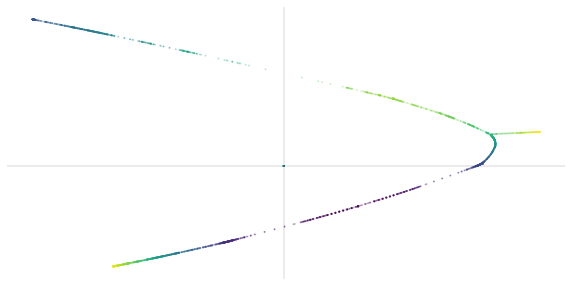

In [14]:
figsize(10,5);
axis('off');
scatter(g1_embedding.embedding_[:,1],
        g1_embedding.embedding_[:,0],
        s=1,
        c=g1_embedding.embedding_[:,2],
        alpha=0.25,
        );
axhline(0,color='black',alpha=0.1);
axvline(0,color='black',alpha=0.1);

In [15]:
g12 = np.concatenate([g1, g2])

In [16]:
g12_matrix = scipy.sparse.coo_matrix(
    (np.ones(len(g12)),(g12[:,0],g12[:,1])),
    shape=(n,n))

In [17]:
%%time
g12_embedding = sklearn.manifold.SpectralEmbedding(
    n_components=3,
    affinity='precomputed')

g12_embedding.fit(g12_matrix)

CPU times: user 56.5 s, sys: 49.6 s, total: 1min 46s
Wall time: 8.86 s


SpectralEmbedding(affinity='precomputed', n_components=3)

In [63]:
g12_embedding.embedding_.shape
positions = np.array([(-s.position.y, s.position.x, 0) for s in embedding.keys()])
# Mixing favoring the embedding
g12_positions_emb = g12_embedding.embedding_ + positions * 1/10000

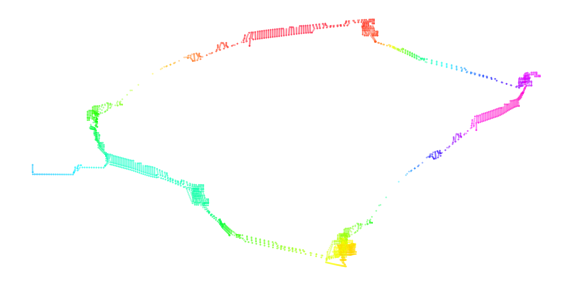

In [64]:
#cmap = cm.viridis
cmap = cm.gist_rainbow
figsize(10,5);
axis('off');
scatter(g12_positions_emb[:,1],
        g12_positions_emb[:,0],
        s=1,
        c=g12_positions_emb[:,2],
        alpha=0.25,
        cmap=cmap);
#axhline(0,color='black',alpha=0.1);
#axvline(0,color='black',alpha=0.1);

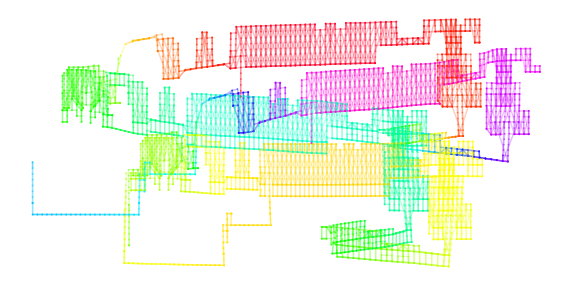

In [67]:
# Mixing favoring the true position
g12_positions_pos = g12_embedding.embedding_ + positions * 1/1000
color_array = g12_positions[:,2]
color_data = cmap(Normalize(min(color_array), max(color_array))(color_array))
figsize(10, 5);
axis('off')
scatter(g12_positions_pos[:,1],
        g12_positions_pos[:,0],
        s=1,
        c=color_data,
        alpha=0.25,
        cmap=cmap);
# Draw the lines
for n1, n2 in g2:
    n1 = int(n1)
    n2 = int(n2)
    x = (g12_positions_pos[n1,1], g12_positions_pos[n2,1])
    y = (g12_positions_pos[n1,0], g12_positions_pos[n2,0])
    plot(x, y, "-", c=color_data[n1], alpha=0.25)

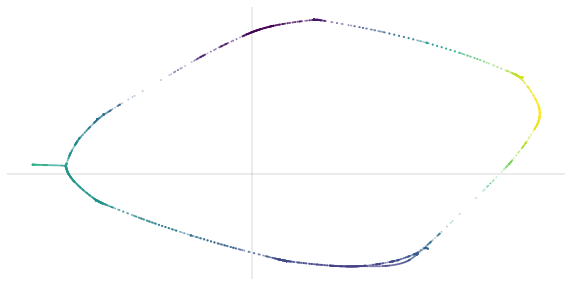

In [36]:
figsize(10,5);
axis('off');
scatter(g12_embedding.embedding_[:,1],
        g12_embedding.embedding_[:,0],
        s=1,
        c=g12_embedding.embedding_[:,2],
        alpha=0.25,
        );
axhline(0,color='black',alpha=0.1);
axvline(0,color='black',alpha=0.1);

In [112]:
goal_state = tests["ModifiedConstructionZone2"][1]
for state in k_c2.S0:
    initial_state = state
softlock_state = c2[2][-1]
big_states = [initial_state, goal_state, softlock_state]

In [113]:
def state_to_color(state):
    color = 0
    i = state.items
    if "M" in i:
        color |= 2**0
    if "MB" in i:
        color |= 2**1
    return color

colors = np.zeros(n, dtype=int)
for state in k_c1.states():
    state_id = embedding[state]
    #colors[state_id] |= 2**0
    colors[state_id] = state_to_color(state)
for state in k_c2.states():
    state_id = embedding[state]
    #colors[state_id] |= 2**1
    colors[state_id] = state_to_color(state)

initial_state_id = embedding[initial_state]
#colors[initial_state_id] = 4
sizes = np.ones(n, dtype=int)
for state in big_states:
    sizes[embedding[state]] = 400

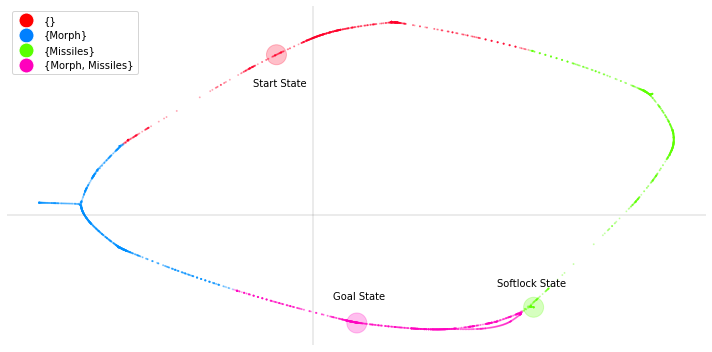

In [149]:
figsize(10,5);
axis('off');
scatter(g12_embedding.embedding_[:,1],
        g12_embedding.embedding_[:,0],
        s=sizes,
        c=colors,
        alpha=0.25,
        cmap="gist_rainbow");
axhline(0,color='black',alpha=0.1);
axvline(0,color='black',alpha=0.1);
legend_elements = [Line2D([0], [0], marker='o', color="w", markerfacecolor=(1, 0, 0), label='{}', markersize=15),
                   Line2D([0], [0], marker='o', color="w", markerfacecolor=(0, 0.5, 1), label='{Morph}', markersize=15),
                   Line2D([0], [0], marker='o', color="w", markerfacecolor=(0.35, 1, 0), label='{Missiles}', markersize=15),
                   Line2D([0], [0], marker='o', color="w", markerfacecolor=(1, 0, 0.74), label='{Morph, Missiles}', markersize=15),
                  ]
legend(handles=legend_elements)
annotate("Start State", xy=(-0.0025, 0.009))
annotate("Goal State", xy=(0.0008, -0.0059))
annotate("Softlock State", xy=(0.0076, -0.0050))
tight_layout()
savefig("embedding.pdf")